In [ ]:
cd "C:\Users\Shreya\Desktop\Final Year Project"

C:\Users\Shreya\Desktop\Final Year Project


In [ ]:
import mne
%matplotlib inline
import numpy as np

# Mention the file path to the dataset
filename = "./BCICIV_2a_gdf/A01T.gdf"

raw=mne.io.read_raw_gdf(r'C:\Users\Shreya\Desktop\Final Year Project\BCICIV_2a_gdf\A01T.gdf')

print(raw.info)
print(raw.ch_names)

Extracting EDF parameters from C:\Users\Shreya\Desktop\Final Year Project\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 7 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
>
['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']


c:\users\shreya\envs\pes_ai_pip\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
<ipython-input-3-53da10cc63e4>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_gdf(r'C:\Users\Shreya\Desktop\Final Year Project\BCICIV_2a_gdf\A01T.gdf')


In [ ]:
events, _ = mne.events_from_annotations(raw)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [ ]:
raw.load_data()

Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

In [ ]:
raw_tmp=raw.copy()

In [ ]:
raw_tmp.filter(7., 35., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)



<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

In [ ]:
raw_tmp.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']

picks = mne.pick_types(raw_tmp.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude='bads')

In [ ]:
tmin, tmax = 1., 4.
# left_hand = 769,right_hand = 770,foot = 771,tongue = 772
event_id = dict({'769': 7,'770': 8,'771': 9,'772': 10})

epochs = mne.Epochs(raw_tmp, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 751 original time points ...
0 bad epochs dropped


In [ ]:
evoked = epochs['769']
print(evoked)
evoked.plot(time_unit='s')

# Right hand epoch average plot

evoked = epochs['770'].average()
print(evoked)
evoked.plot(time_unit='s')

# Foot epoch average plot

evoked = epochs['771'].average()
print(evoked)
evoked.plot(time_unit='s')

# Tongue epoch average plot

evoked = epochs['772'].average()
print(evoked)
evoked.plot(time_unit='s')

NameError: name 'epochs' is not defined

In [ ]:
labels = epochs.events[:,-1] - 7 + 1 

data = epochs.get_data()

Not setting metadata
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


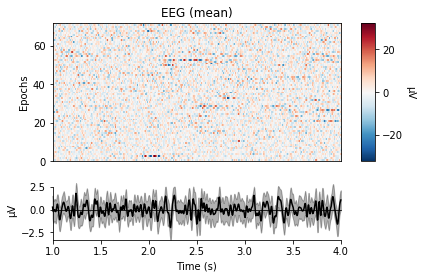

[<Figure size 432x288 with 3 Axes>]

In [ ]:
epochs['772'].plot_image(picks='eeg', combine='mean')

In [ ]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
import pywt

In [ ]:
import pywt

# signal is decomposed to level 5 with 'db4' wavelet

def wpd(X): 
    coeffs = pywt.WaveletPacket(X,'db4',mode='symmetric',maxlevel=5)
    return coeffs
             
def feature_bands(x):
    
    Bands = np.empty((8,x.shape[0],x.shape[1],30)) # 8 freq band coefficients are chosen from the range 4-32Hz
    
    for i in range(x.shape[0]):
        for ii in range(x.shape[1]):
             pos = []
             C = wpd(x[i,ii,:]) 
             pos = np.append(pos,[node.path for node in C.get_level(5, 'natural')])
             for b in range(1,9):
                 Bands[b-1,i,ii,:] = C[pos[b]].data
        
    return Bands

wpd_data = feature_bands(data)

In [ ]:
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from sklearn.model_selection import ShuffleSplit

# OneHotEncoding Labels
enc = OneHotEncoder()
X_out = enc.fit_transform(labels.reshape(-1,1)).toarray()

# Cross Validation Split
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

acc = []
ka = []
prec = []
recall = []

Using TensorFlow backend.


In [ ]:
def build_classifier(num_layers = 1):
    classifier = Sequential()
    #First Layer
    classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', input_dim = 32, 
                         kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
    classifier.add(Dropout(0.5))
    # Intermediate Layers
    for itr in range(num_layers):
        classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', 
                             kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.5))   
    # Last Layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [ ]:
for train_idx, test_idx in cv.split(labels):
    
    Csp = [];ss = [];nn = [] # empty lists
    
    label_train, label_test = labels[train_idx], labels[test_idx]
    y_train, y_test = X_out[train_idx], X_out[test_idx]
    
    # CSP filter applied separately for all Frequency band coefficients
    
    Csp = [CSP(n_components=4, reg=None, log=True, norm_trace=False) for _ in range(8)]
    ss = preprocessing.StandardScaler()

    X_train = ss.fit_transform(np.concatenate(tuple(Csp[x].fit_transform(wpd_data[x,train_idx,:,:],label_train) for x  in range(8)),axis=-1))

    X_test = ss.transform(np.concatenate(tuple(Csp[x].transform(wpd_data[x,test_idx,:,:]) for x  in range(8)),axis=-1))
    
    nn = build_classifier()  
    
    nn.fit(X_train, y_train, batch_size = 32, epochs = 300)
    
    y_pred = nn.predict(X_test)
    pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

    acc.append(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
    ka.append(cohen_kappa_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
    prec.append(precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    recall.append(recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))


Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)


In [ ]:
import pandas as pd

scores = {'Accuracy':acc,'Kappa':ka,'Precision':prec,'Recall':recall}

Es = pd.DataFrame(scores)

avg = {'Accuracy':[np.mean(acc)],'Kappa':[np.mean(ka)],'Precision':[np.mean(prec)],'Recall':[np.mean(recall)]}

Avg = pd.DataFrame(avg)


T = pd.concat([Es,Avg])

T.index = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','Avg']
T.index.rename('Fold',inplace=True)

print(T)

      Accuracy     Kappa  Precision    Recall
Fold                                         
F1    0.689655  0.587025   0.708298  0.689655
F2    0.672414  0.559904   0.696898  0.672414
F3    0.689655  0.588490   0.723145  0.689655
F4    0.689655  0.586207   0.711646  0.689655
F5    0.827586  0.770024   0.834524  0.827586
F6    0.603448  0.464257   0.626324  0.603448
F7    0.637931  0.512410   0.647733  0.637931
F8    0.689655  0.578352   0.721591  0.689655
F9    0.655172  0.532823   0.660504  0.655172
F10   0.810345  0.743775   0.817501  0.810345
Avg   0.696552  0.592327   0.714816  0.696552
